In [1]:
import numpy as np
import matplotlib.pyplot as plt

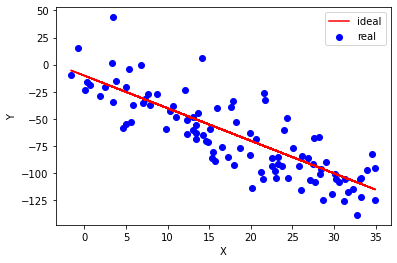

In [2]:
# 从 -2 到 35间均匀采样，间隔为0.01
X = np.random.choice(range(-200, 3501), 100, replace=False) / 100

k = -3
b = -10

Y_ideal = k * X + b  # 理想值
Y_real = Y_ideal + np.random.randn(X.shape[0]) * 20  # 真实值，带噪声

plt.plot(X, Y_ideal, label='ideal', color='r')
plt.scatter(X, Y_real, label='real', color='b')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.savefig(r'E:\particle\imgs\fitLine\1.png')

In [3]:
def show(k, b):
    plt.plot(X, X * k + b, label='pred', color='g')
    plt.plot(X, Y_ideal, label='ideal', color='r')
    plt.scatter(X, Y_real, label='real', color='b')
    plt.legend()

## 最小二乘法

In [4]:
def leastSquaresMethod(X, Y):
    X = np.hstack([X[:, None], np.ones((X.shape[0], 1))])  # (m, 2)
    W = np.linalg.inv(X.T @ X) @ X.T @ Y
    return W[0], W[1]

-3.0595814353393687 -11.37789560282475


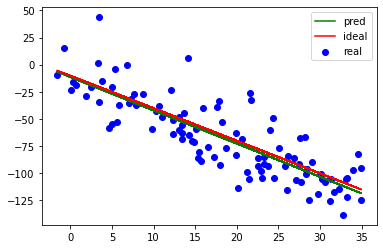

In [5]:
k, b = leastSquaresMethod(X, Y_real)
print(k, b)
show(k, b)

## PyTorch 逻辑回归

-3.243736743927002 -7.009946823120117


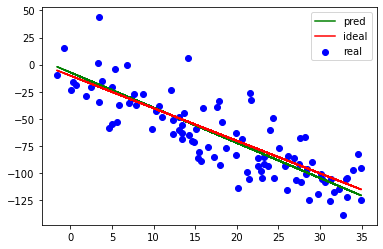

In [6]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, k=1, b=0):
        super().__init__()
        weight = torch.tensor([k]).float()
        bias = torch.tensor([b]).float()
        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(bias)
    
    def forward(self, x):
        return x * self.weight + self.bias
        

def wtf(X, Y):
    net = Net()
    X_pytorch = torch.from_numpy(X)
    Y_pytorch = torch.from_numpy(Y)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.002)
    for epoch in range(1000):
        optimizer.zero_grad()
        Y_pred = net(X_pytorch)
        loss = criterion(Y_pytorch, Y_pred)
#         print(loss.item())
        loss.backward()
        optimizer.step()
    return net.weight.item(), net.bias.item()
k, b = wtf(X, Y_real)
print(k, b)
show(k, b)

## Numpy 逻辑回归

-3.2437364075224546 -7.009949690391845


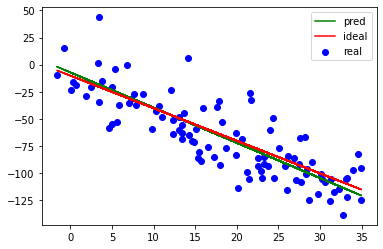

In [7]:
def linearRegression(X, Y):
    k = 1
    b = 0
    lr = 0.002
    batch_size = X.shape[0]
    for epoch in range(1000):
        Y_pred = X * k + b
        err = (Y_pred - Y) ** 2  # (m,)
        derrdy = 2 * Y_pred.T - 2 * Y.T  # (1,m)
        derrdk = derrdy @ X  # (1,)
        derrdb = derrdy @ np.ones_like(Y)  # (1,)
        # 注意上面求得的梯度与数据的数量有关系，需要除以batch_size
        k -= lr*derrdk / batch_size
        b -= lr*derrdb / batch_size
    return k, b
k, b = linearRegression(X, Y_real)
print(k, b)
show(k, b)

## RANSAC

-3.042740839412021 -15.565352296119947


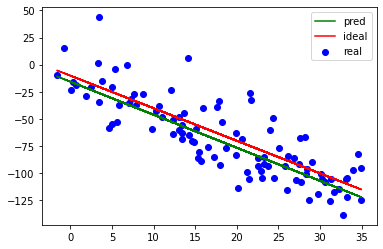

In [8]:
def ransac(X, Y, d=4, iteration=100):
    n = X.shape[0]
    m = min(10, max(2, n//10))
    indexs = np.random.choice(range(n), size=(m), replace=False)
    max_num = 0
    res = None
    for i in range(100):
        k, b = leastSquaresMethod(X[indexs], Y[indexs])
        dist = np.abs(k*X-Y+b)/np.sqrt(k**2+1)
        indexs = dist < d
        num_inlier = indexs.sum()
        if num_inlier > max_num:
            res = (k, b)
    return res
k, b = ransac(X, Y_real, d=10, iteration=100)
print(k, b)
show(k, b)